# Preparing Part

#### Important imports and array handling and plotting

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import os
os.environ['TP_CPP_MIN_LOG_LEVEL']='3'

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras import backend as K

Using TensorFlow backend.


#### Loading dataset and splitting it into train and test sets

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Plotting some examples

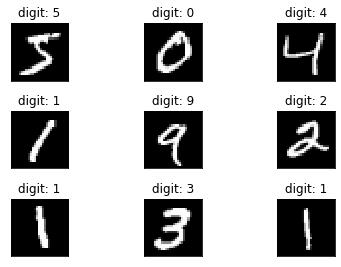

In [6]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

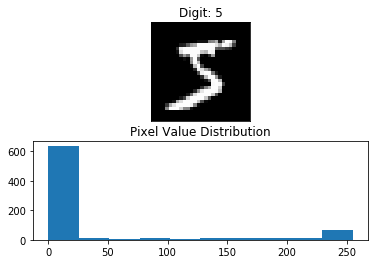

In [7]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

In [8]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### This section is for inputs for convolutional layer. use X_train_conv for conv layers

In [9]:
# input image dimensions
img_x, img_y = 28, 28
# saving the input as 28x28 pixels for convolutional networks
X_train_conv = X_train.reshape(X_train.shape[0], img_x, img_y, 1)
X_test_conv = X_test.reshape(X_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)
# convert the data to the right type
X_train_conv = X_train_conv.astype('float32')
X_test_conv = X_test_conv.astype('float32')
X_train_conv /= 255
X_test_conv /= 255
print('x_train shape:', X_train_conv.shape)
print(X_train_conv.shape[0], 'train samples')
print(X_test_conv.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### This section is for inputs for Dense layer. use X_train for Dense layers

In [10]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [11]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [12]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [13]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))


### This output can be used both for conv and Dense layers

In [14]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_test.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (10000, 10)


# Reference Part

In [13]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

In [ ]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "C:\\Users\\Christopher Balnaves\\Documents"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')

plt.tight_layout()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 11s - loss: 0.2474 - accuracy: 0.9264 - val_loss: 0.1023 - val_accuracy: 0.9679
Epoch 2/20
 - 10s - loss: 0.1032 - accuracy: 0.9685 - val_loss: 0.0837 - val_accuracy: 0.9734
Epoch 3/20
 - 12s - loss: 0.0718 - accuracy: 0.9772 - val_loss: 0.0737 - val_accuracy: 0.9763
Epoch 4/20
 - 11s - loss: 0.0565 - accuracy: 0.9817 - val_loss: 0.0687 - val_accuracy: 0.9794
Epoch 5/20
 - 11s - loss: 0.0462 - accuracy: 0.9849 - val_loss: 0.0616 - val_accuracy: 0.9812
Epoch 6/20


In [28]:
mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist - Keep.h5")
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

ValueError: Error when checking input: expected dense_1_input to have 2 dimensions, but got array with shape (10000, 28, 28)

In [ ]:
# load the model and create predictions on the test set
mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist.h5")
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

#### Plotting ROC and Precision-Recall Curves are done at the end of the Notebook, in the same command as the optimal model

# Experimenting Part

### Comparing the Training Optimization Algorithm

In [ ]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model
# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

The results suggest that the "Adadelta" optimization algorithm is the best with a score of "98%" accuracy.

### Comparing Batch Size and Number of Epochs

In [ ]:
def create_model1():
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adadelta')
    
    return model

# create model
model = KerasClassifier(build_fn=create_model1, verbose=0)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs = [10, 20, 25]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

We can see that the batch size of 128 and 25 epochs achieved the best result of about 98% accuracy.

### Comparing Learning Rate and Momentum

In [ ]:
from keras.optimizers import SGD

In [ ]:
def create_model2(learn_rate=0.01, momentum=0):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model2, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.3, 0.6, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Comparing Activation Function

In [ ]:
def create_model3(activation='relu'):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation(activation))                            
    model.add(Dropout(0.2))

    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model3, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Comparing Dropout

In [ ]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model4(dropout=0.2):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(dropout))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model4, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8]
param_grid = dict(dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Comparing Number of Hidden Layers

In [ ]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model5(num_layers=2):
	# create model
    model = Sequential()
    for x in range(num_layers):
        model.add(Dense(512, input_shape=(784,)))
        model.add(Activation('relu'))                            
        model.add(Dropout(0.2))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

# create model
model = KerasClassifier(build_fn=create_model5, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
num_layers = [0, 1, 2, 4, 8, 12, 16]
param_grid = dict(num_layers=num_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Comparing Loss Function

In [82]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model6(loss='kullback_leibler_divergence'):
	# create model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.3))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    return model
# create model
model = KerasClassifier(build_fn=create_model6, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
loss = ['categorical_hinge', 'categorical_crossentropy', 'kullback_leibler_divergence']
param_grid = dict(loss=loss)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.979883 using {'loss': 'categorical_crossentropy'}
0.976100 (0.001919) with: {'loss': 'categorical_hinge'}
0.979883 (0.001438) with: {'loss': 'categorical_crossentropy'}
0.979650 (0.000349) with: {'loss': 'kullback_leibler_divergence'}


### Comparing Hidden Layer Types

In [7]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model7(choice='MaxPooling2D'):
    #inputShape = (28, 28, 1)
    #if K.image_data_format() == "channels_first":
    #    inputShape = (1, 28, 28)
    # create model
    model = Sequential()
    if (choice == 'Conv'):
        model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (5, 5), activation='relu'))
        model.add(Dropout(0.3))
        model.add(Flatten())   
        
    elif (choice == 'MaxPooling2D'):
        model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Conv2D(64, (5, 5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))
        model.add(Flatten())
        
    elif (choice == 'AveragePooling2D'):
        model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Conv2D(64, (5, 5), activation='relu'))
        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))
        model.add(Flatten()) 

    elif (choice == 'GlobalMaxPooling2D'):
        model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (5, 5), activation='relu'))
        model.add(GlobalMaxPooling2D())
        model.add(Dropout(0.3))
        
    elif (choice == 'GlobalAveragePooling2D'):
        model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (5, 5), activation='relu'))
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(0.3))
        
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model
# create model
model = KerasClassifier(build_fn=create_model7, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
choice = ['MaxPooling2D', 'AveragePooling2D', 'GlobalAveragePooling2D', 'GlobalMaxPooling2D']
param_grid = dict(choice=choice)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

#img_rows=X_train_conv[0].shape[0]
#img_cols=X_train_conv[0].shape[1]
#if K.image_data_format() == "channels_first":
#    X_train_conv=X_train_conv.reshape(X_train_conv.shape[0],1,img_rows,img_cols)
#else:
#    X_train_conv=X_train_conv.reshape(X_train_conv.shape[0],img_rows,img_cols,1)
grid_result = grid.fit(X_train_conv, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.990750 using {'choice': 'MaxPooling2D'}
0.990750 (0.001071) with: {'choice': 'MaxPooling2D'}
0.989633 (0.000715) with: {'choice': 'AveragePooling2D'}
0.971717 (0.000455) with: {'choice': 'GlobalAveragePooling2D'}
0.984400 (0.001175) with: {'choice': 'GlobalMaxPooling2D'}


### Comparing Number of filters and kernel sizes

In [13]:
# building a linear stack of layers with the sequential model
# Function to create model, required for KerasClassifier
def create_model7(nb_filters=(32,64), kernel_size=(3,3)):

    # create model
    model = Sequential()
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(nb_filters[1], kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    optimizer = SGD(lr=0.2, momentum=0.6)
    
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model
# create model
model = KerasClassifier(build_fn=create_model7, epochs=20, batch_size=128, verbose=0)
# define the grid search parameters
kernel_size = [(1,1), (3,3), (5,5)]
nb_filters = [(16,32), (32,64), (64,128)]
param_grid = dict(kernel_size=kernel_size, nb_filters=nb_filters)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_conv, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.991150 using {'kernel_size': (5, 5), 'nb_filters': (64, 128)}
0.869800 (0.002718) with: {'kernel_size': (1, 1), 'nb_filters': (16, 32)}
0.868650 (0.008125) with: {'kernel_size': (1, 1), 'nb_filters': (32, 64)}
0.884417 (0.006694) with: {'kernel_size': (1, 1), 'nb_filters': (64, 128)}
0.986700 (0.000991) with: {'kernel_size': (3, 3), 'nb_filters': (16, 32)}
0.988733 (0.001115) with: {'kernel_size': (3, 3), 'nb_filters': (32, 64)}
0.989667 (0.000595) with: {'kernel_size': (3, 3), 'nb_filters': (64, 128)}
0.989133 (0.000131) with: {'kernel_size': (5, 5), 'nb_filters': (16, 32)}
0.991067 (0.000726) with: {'kernel_size': (5, 5), 'nb_filters': (32, 64)}
0.991150 (0.000122) with: {'kernel_size': (5, 5), 'nb_filters': (64, 128)}


# Optimal Part

#### Using the determined optimal parameters: Opimizer = SGD, Learning Rate = 0.2, Momentum = 0.6, Activation function = Relu, Batch size = 128, Nb of epochs = 25, Nb of hidden layers = 2, Dropout = 0.2

In [18]:
nb_filters=(64,128)
kernel_size=(5,5)

model = Sequential()
model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(nb_filters[1], kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))
    
optimizer = SGD(lr=0.2, momentum=0.6)
    
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [22]:
# training the model and saving metrics in history
history = model.fit(X_train_conv, Y_train,
          batch_size=128, epochs=25,
          verbose=2,
          validation_data=(X_test_conv, Y_test))

# saving the model
save_dir = "C:\\Users\\Christopher Balnaves\\Documents"
model_name = 'keras_mnist_sgd.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')

plt.tight_layout()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 - 72s - loss: 0.2212 - accuracy: 0.9352 - val_loss: 0.0456 - val_accuracy: 0.9844
Epoch 2/25
 - 68s - loss: 0.0581 - accuracy: 0.9817 - val_loss: 0.0343 - val_accuracy: 0.9883
Epoch 3/25
 - 66s - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.0273 - val_accuracy: 0.9915
Epoch 4/25
 - 64s - loss: 0.0378 - accuracy: 0.9880 - val_loss: 0.0255 - val_accuracy: 0.9908
Epoch 5/25
 - 65s - loss: 0.0312 - accuracy: 0.9898 - val_loss: 0.0238 - val_accuracy: 0.9924
Epoch 6/25
 - 70s - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.0216 - val_accuracy: 0.9926
Epoch 7/25
 - 77s - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0242 - val_accuracy: 0.9914
Epoch 8/25
 - 71s - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0236 - val_accuracy: 0.9923
Epoch 9/25
 - 66s - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0203 - val_accuracy: 0.9930
Epoch 10/25
 - 70s - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0226 - val_accuracy: 0.9928
Epoch 11/

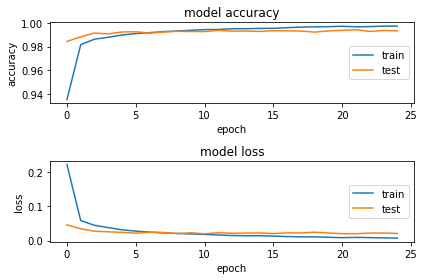

In [24]:
fig

In [25]:
mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist_sgd.h5")
loss_and_metrics = mnist_model.evaluate(X_test_conv, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 0.020746029271234177
Test Accuracy 0.993399977684021


In [27]:
# load the model and create predictions on the test set
mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist_sgd.h5")
predicted_classes = mnist_model.predict_classes(X_test_conv)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


9934  classified correctly
66  classified incorrectly


## Plotting ROC and Precision-Recall Curves

### ROC Curve

In [35]:
#mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist.h5")
mnist_model = load_model("C:\\Users\\Christopher Balnaves\\Documents\\keras_mnist_sgd.h5")
y_score = mnist_model.predict(X_test_conv) 
print(y_score.shape)

(10000, 10)


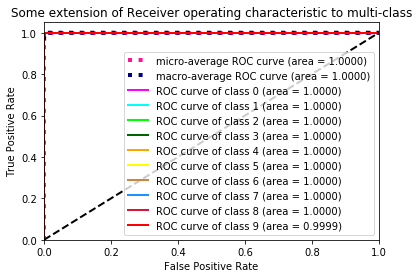

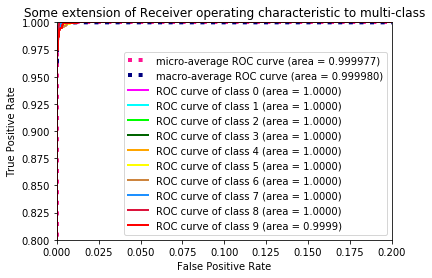

In [43]:
%matplotlib inline
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['magenta','cyan','lime','darkgreen','orange','yellow','peru','dodgerblue','crimson','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['magenta','cyan','lime','darkgreen','orange','yellow','peru','dodgerblue','crimson','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



### Micro-Averaged Precision-Recall curve

#### The average precision score

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.9998')

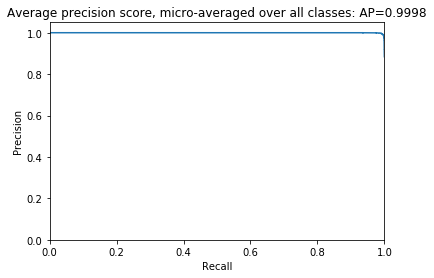

In [40]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.4f}'
    .format(average_precision["micro"]))


#### Plot Precision-Recall curve for each class and iso-f1 curves

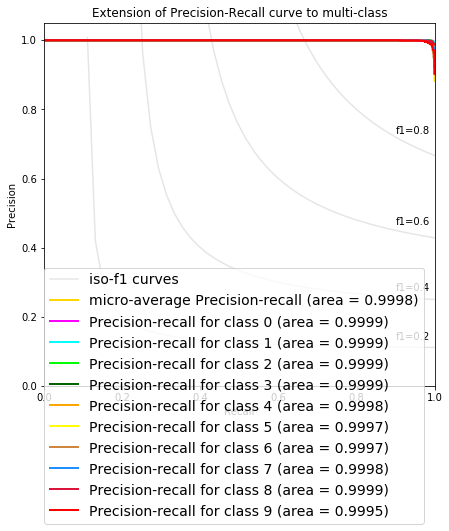

In [42]:
from itertools import cycle
# setup plot details
colors = cycle(['magenta','cyan','lime','darkgreen','orange','yellow','peru','dodgerblue','crimson','red'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.4f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.4f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()